In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
sim_list = ['fRpoly-Rcore1.0', 'fRpoly-Rcore1.0-barGas2.0', 'fRpoly-Rcore1.0-spring']

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

In [3]:
def get_n_T(rho, u, xe, XH=0.76):
    GAMMA = 5./3.
    BOLTZMANN = 1.38065e-16
    PROTONMASS = 1.67262178e-24
    UnitLength_in_cm = 3.08568e+21
    UnitMass_in_g = 1.989e+43
    UnitVelocity_in_cm_per_s = 100000
    UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
    UnitEnergy_in_cgs = UnitMass_in_g * UnitLength_in_cm**2 / (UnitTime_in_s**2)
    
    mu = (4 * PROTONMASS) / (1. + 3*XH + 4 * XH * xe)
    T = (GAMMA - 1.) * (u/BOLTZMANN) * (UnitEnergy_in_cgs/UnitMass_in_g) * mu
    
    n = UnitMass_in_g * rho / mu # in kpc^-3
    n *= UnitLength_in_cm**(-3.)
    
    return n, T


In [10]:
tlist = []
gas_mass = []
gas_mass_outR = []
gas_mass_outR2 = []
gas_mass_barred = []
gas_mass_outR_barred = []
gas_mass_outR2_barred = []
sfr_outR = []
sfr_outR2 = []
sfr_outR_barred = []
sfr_outR2_barred = []

center = np.array([200, 200, 200])
Rout = 2.
Rout2 = 15.

for i in tqdm(np.arange(0, 400, 20)):
    sn = read_snap(i, 0, lvl='lvl4', fields=['Coordinates', 'Masses', 'StarFormationRate', 'InternalEnergy', 'ElectronAbundance'])
    gas_mass.append(np.sum(sn.part0.mass))
    pos = sn.part0.pos - center
    R = np.linalg.norm(pos[:,:2], axis=1)
    key = np.where(R > Rout)[0]
    gas_mass_outR.append(np.sum(sn.part0.mass[key]))
    sfr_outR.append(np.sum(sn.part0.sfr[key]))
    
    key = np.where(R > Rout2)[0]
    gas_mass_outR2.append(np.sum(sn.part0.mass[key]))
    sfr_outR2.append(np.sum(sn.part0.sfr[key]))
    
    sn = read_snap(i, 1, lvl='lvl4', fields=['Coordinates', 'Masses', 'StarFormationRate', 'InternalEnergy', 'ElectronAbundance'])
    gas_mass_barred.append(np.sum(sn.part0.mass))
    pos = sn.part0.pos - center
    R = np.linalg.norm(pos[:,:2], axis=1)
    key = np.where(R > Rout)[0]
    gas_mass_outR_barred.append(np.sum(sn.part0.mass[key]))
    sfr_outR_barred.append(np.sum(sn.part0.sfr[key]))
    
    key = np.where(R > Rout2)[0]
    gas_mass_outR2_barred.append(np.sum(sn.part0.mass[key]))
    sfr_outR2_barred.append(np.sum(sn.part0.sfr[key]))
    
    tlist.append(sn.Time)

100%|██████████| 20/20 [00:51<00:00,  2.68s/it]


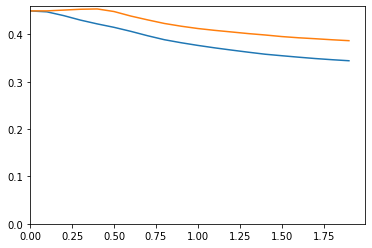

In [9]:
plt.plot(tlist, gas_mass)
plt.plot(tlist, gas_mass_barred)
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

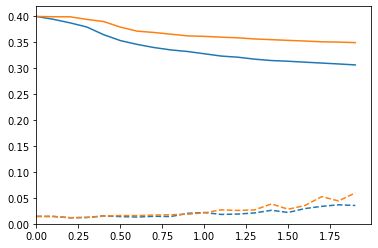

In [12]:
l = plt.plot(tlist, gas_mass_outR, label='R>2 kpc')
plt.plot(tlist, gas_mass_outR2, c=l[0].get_color(), label='R > 15 kpc', ls='dashed')
l = plt.plot(tlist, gas_mass_outR_barred)
plt.plot(tlist, gas_mass_outR2_barred, c=l[0].get_color(), label='R > 15 kpc', ls='dashed')
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

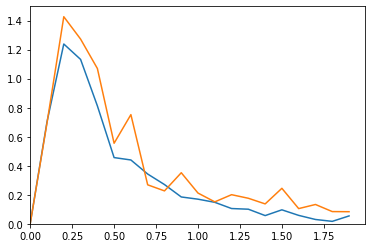

In [11]:
plt.plot(tlist, sfr_outR)
plt.plot(tlist, sfr_outR_barred)
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

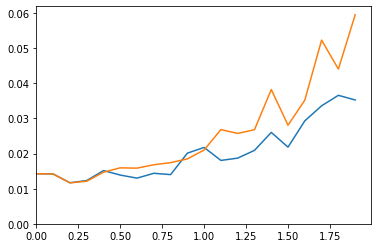

In [13]:
plt.plot(tlist, gas_mass_outR2)
plt.plot(tlist, gas_mass_outR2_barred)
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

In [6]:
sn = read_snap(150, 0, lvl='lvl4', fields=['Coordinates', 'Masses', 'StarFormationRate', 'InternalEnergy', 'ElectronAbundance'])
n, T = get_n_T(sn.part0.mass, sn.part0.u, sn.part0.ne)

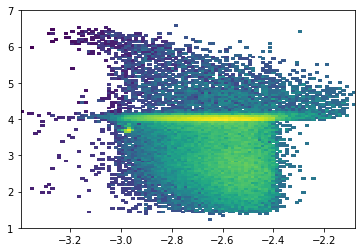

In [9]:
from matplotlib.colors import LogNorm
logT = np.log10(T)
logn = np.log10(n)
plt.hist2d(np.array(logn), np.array(logT), bins=100, weights=sn.part0.mass, norm=LogNorm())
# plt.xlim(-6, 8)
plt.ylim(1, 7)
plt.show()

## Remaking the Big Disk Plot - lvl4

In [4]:
def disk_decomp(idx_list, snap_idx, lvl='lvl4', prop='mass', Rcut=15.0, Rcut2=30.0, zmax=3, center=np.array([200, 200, 200])):
    tlist = []
    tot_gas = []
    in_disk = []
    in_bigdisk = []
    out_disk = []
    in_star = []
    for idx in tqdm(idx_list):
        sn = read_snap(idx, snap_idx, lvl=lvl, parttype=[0,4], fields=['Coordinates', 'Masses', 'StarFormationRate'])
        
        tlist.append(sn.Time)
        
        pos = sn.part0.pos - center
        R = np.linalg.norm(pos[:,:2], axis=1)
        z = np.abs(pos[:,2])
        
        key_in_disk = np.logical_and(R < Rcut, z < zmax)
        key_in_bigdisk = np.logical_and(np.logical_and(R > Rcut, R < Rcut2), z < zmax)
        key_out_disk = np.logical_or(R > Rcut2, z > zmax)
        
        qty = getattr(sn.part0, prop)
        
        tot_gas.append(np.sum(qty))
        in_disk.append(np.sum(qty[key_in_disk]))
        in_bigdisk.append(np.sum(qty[key_in_bigdisk]))
        out_disk.append(np.sum(qty[key_out_disk]))
        
        if sn.NumPart_Total[4] > 0.0:
            in_star.append(np.sum(sn.part4.mass))
        else:
            in_star.append(0.)
    
    return np.array(tlist), np.array(tot_gas), np.array(in_disk), np.array(in_bigdisk), np.array(out_disk), np.array(in_star)


In [11]:
tlist, tot_gas, in_disk, in_bigdisk, out_disk, in_star = disk_decomp(np.arange(0, 600, 10), 0, Rcut=16.5, zmax=4)
tlist_b, tot_gas_b, in_disk_b, in_bigdisk_b, out_disk_b, in_star_b = disk_decomp(np.arange(0, 600, 10), 1, Rcut=16.5, zmax=4)
tlist_s, tot_gas_s, in_disk_s, in_bigdisk_s, out_disk_s, in_star_s = disk_decomp(np.arange(0, 600, 10), 2, Rcut=16.5, zmax=4)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [12]:
tlist, tot_sfr, sfr_in_disk, sfr_in_bigdisk, sfr_out_disk, sfr_in_star = disk_decomp(np.arange(0, 600, 10), 0, Rcut=16.5, zmax=4, prop='sfr')
tlist_b, tot_sfr_b, sfr_in_disk_b, sfr_in_bigdisk_b, sfr_out_disk_b, sfr_in_star_b = disk_decomp(np.arange(0, 600, 10), 1, Rcut=16.5, zmax=4, prop='sfr')
tlist_s, tot_sfr_s, sfr_in_disk_s, sfr_in_bigdisk_s, sfr_out_disk_s, sfr_in_star_s = disk_decomp(np.arange(0, 600, 10), 2, Rcut=16.5, zmax=4, prop='sfr')

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

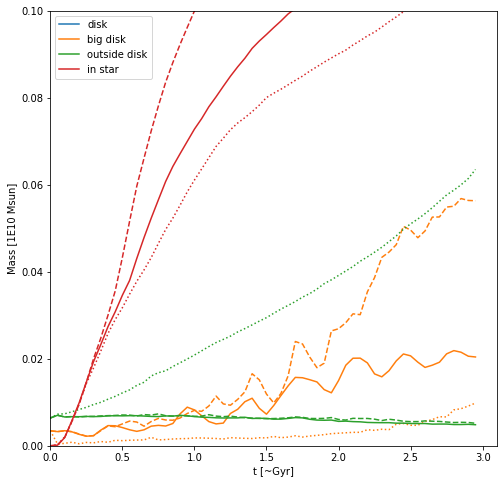

In [25]:
tot_mass = in_disk + in_bigdisk + out_disk + in_star

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

l = ax.plot(tlist, in_disk, label='disk')
ax.plot(tlist_b, in_disk_b, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s, in_disk_s, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist, in_bigdisk, label='big disk')
ax.plot(tlist_b, in_bigdisk_b, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s, in_bigdisk_s, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist, out_disk, label='outside disk')
ax.plot(tlist_b, out_disk_b, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s, out_disk_s, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist, in_star, label='in star')
ax.plot(tlist_b, in_star_b, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s, in_star_s, c=l[0].get_color(), ls='dotted')

ax.legend()
ax.set(xlim=(0, None), ylim=(0, 0.1), xlabel='t [~Gyr]', ylabel='Mass [1E10 Msun]')
plt.show()

In [14]:
(out_disk_s[-1]-out_disk_s[0]) / (tlist_s[-1]-tlist_s[0])

0.019371218335664023

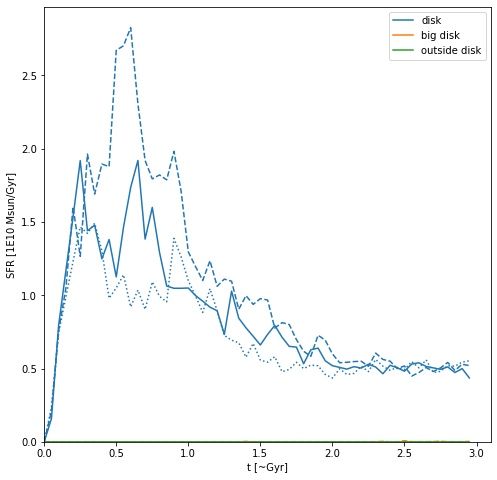

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

l = ax.plot(tlist, sfr_in_disk, label='disk')
ax.plot(tlist_b, sfr_in_disk_b, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s, sfr_in_disk_s, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist, sfr_in_bigdisk, label='big disk')
ax.plot(tlist_b, sfr_in_bigdisk_b, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s, sfr_in_bigdisk_s, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist, sfr_out_disk, label='outside disk')
ax.plot(tlist_b, sfr_out_disk_b, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s, sfr_out_disk_s, c=l[0].get_color(), ls='dotted')

ax.legend()
ax.set(xlim=(0, None), ylim=(0, None), xlabel='t [~Gyr]', ylabel='SFR [1E10 Msun/Gyr]')
plt.show()

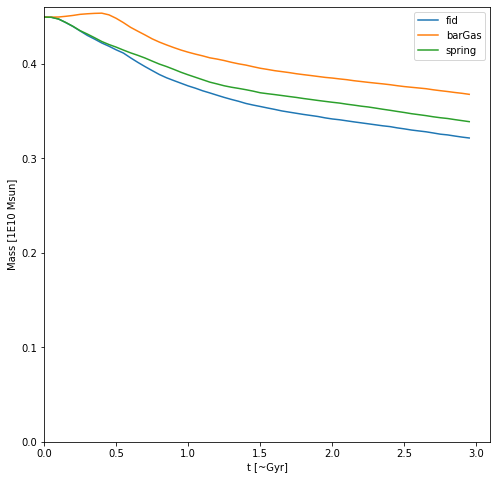

In [16]:
tot_mass = in_disk + in_bigdisk + out_disk + in_star

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.plot(tlist, tot_gas, label='fid')
ax.plot(tlist_b, tot_gas_b, label='barGas')
ax.plot(tlist_s, tot_gas_s, label='spring')

ax.legend()
ax.set(xlim=(0, None), ylim=(0, None), xlabel='t [~Gyr]', ylabel='Mass [1E10 Msun]')
plt.show()

## Remaking the Big Disk Plot - lvl3

In [17]:
tlist3, tot_gas3, in_disk3, in_bigdisk3, out_disk3, in_star3 = disk_decomp(np.arange(0, 600, 10), 0, Rcut=16.5, zmax=4, lvl='lvl3')
tlist_b3, tot_gas_b3, in_disk_b3, in_bigdisk_b3, out_disk_b3, in_star_b3 = disk_decomp(np.arange(0, 180, 10), 1, Rcut=16.5, zmax=4, lvl='lvl3')
tlist_s3, tot_gas_s3, in_disk_s3, in_bigdisk_s3, out_disk_s3, in_star_s3 = disk_decomp(np.arange(0, 120, 10), 2, Rcut=16.5, zmax=4, lvl='lvl3')

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [20]:
tlist3, tot_sfr3, sfr_in_disk3, sfr_in_bigdisk3, sfr_out_disk3, sfr_in_star3 = disk_decomp(np.arange(0, 600, 10), 0, Rcut=16.5, zmax=4, prop='sfr', lvl='lvl3')
tlist_b3, tot_sfr_b3, sfr_in_disk_b3, sfr_in_bigdisk_b3, sfr_out_disk_b3, sfr_in_star_b3 = disk_decomp(np.arange(0, 180, 10), 1, Rcut=16.5, zmax=4, prop='sfr', lvl='lvl3')
tlist_s3, tot_sfr_s3, sfr_in_disk_s3, sfr_in_bigdisk_s3, sfr_out_disk_s3, sfr_in_star_s3 = disk_decomp(np.arange(0, 120, 10), 2, Rcut=16.5, zmax=4, prop='sfr', lvl='lvl3')

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

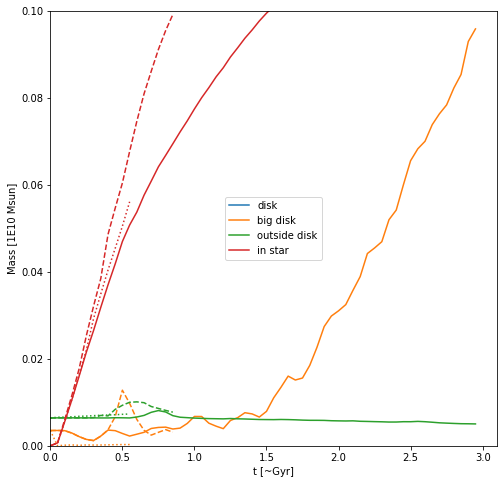

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

l = ax.plot(tlist3, in_disk3, label='disk')
ax.plot(tlist_b3, in_disk_b3, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s3, in_disk_s3, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist3, in_bigdisk3, label='big disk')
ax.plot(tlist_b3, in_bigdisk_b3, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s3, in_bigdisk_s3, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist3, out_disk3, label='outside disk')
ax.plot(tlist_b3, out_disk_b3, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s3, out_disk_s3, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist3, in_star3, label='in star')
ax.plot(tlist_b3, in_star_b3, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s3, in_star_s3, c=l[0].get_color(), ls='dotted')

ax.legend()
ax.set(xlim=(0, None), ylim=(0, 0.1), xlabel='t [~Gyr]', ylabel='Mass [1E10 Msun]')
plt.show()

In [ ]:
(out_disk_s[-1]-out_disk_s[0]) / (tlist_s[-1]-tlist_s[0])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

l = ax.plot(tlist3, sfr_in_disk3, label='disk')
ax.plot(tlist_b3, sfr_in_disk_b3, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s3, sfr_in_disk_s3, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist3, sfr_in_bigdisk3, label='big disk')
ax.plot(tlist_b3, sfr_in_bigdisk_b3, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s3, sfr_in_bigdisk_s3, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist3, sfr_out_disk3, label='outside disk')
ax.plot(tlist_b3, sfr_out_disk_b3, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s3, sfr_out_disk_s3, c=l[0].get_color(), ls='dotted')

ax.legend()
ax.set(xlim=(0, None), ylim=(0, None), xlabel='t [~Gyr]', ylabel='SFR [1E10 Msun/Gyr]')
plt.show()

### Global Star Formation Rate

In [27]:
sfr = read_sfr(0, lvl='lvl4')
sfr_b = read_sfr(1, lvl='lvl4')
sfr_s = read_sfr(2, lvl='lvl4')

In [18]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/IPython/core/pylabtools.py:121: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


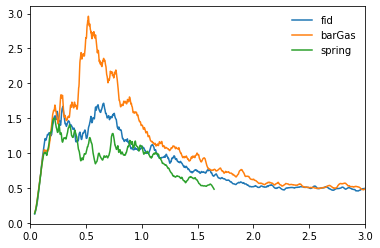

In [29]:
window = 2000

plt.plot(moving_average(sfr[:,0], window), moving_average(sfr[:,2], window), label='fid')
plt.plot(moving_average(sfr_b[:,0], window), moving_average(sfr_b[:,2], window), label='barGas')
plt.plot(moving_average(sfr_s[:,0], window), moving_average(sfr_s[:,2], window), label='spring')

plt.legend(frameon=False)
plt.xlim(0, 3)
plt.show()

In [38]:
sn = read_snap(200, 0, parttype=[0, 3, 4], fields=['Coordinates', 'Masses', 'StarFormationRate'])

1.0


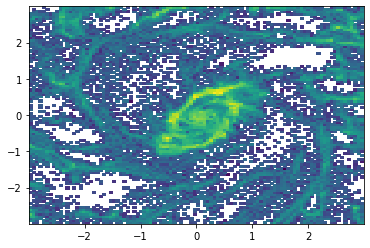

In [32]:
import matplotlib as mpl
xmin = -3
xmax = 3
ymin = -3
ymax = 3

pos = sn.part0.pos - np.array([200, 200, 200])

xbool = np.logical_and(pos[:,0] > xmin, pos[:,0] < xmax)
ybool = np.logical_and(pos[:,1] > ymin, pos[:,1] < ymax)
key = np.logical_and(xbool, ybool)

plt.hist2d(pos[:,0][key], pos[:,1][key], bins=100, weights=sn.part0.mass[key], norm=mpl.colors.LogNorm())
print(sn.Time)
plt.show()

1.0


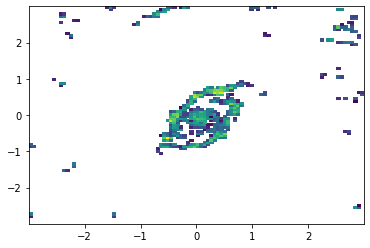

In [33]:
import matplotlib as mpl
xmin = -3
xmax = 3
ymin = -3
ymax = 3

pos = sn.part0.pos - np.array([200, 200, 200])

xbool = np.logical_and(pos[:,0] > xmin, pos[:,0] < xmax)
ybool = np.logical_and(pos[:,1] > ymin, pos[:,1] < ymax)
key = np.logical_and(xbool, ybool)

plt.hist2d(pos[:,0][key], pos[:,1][key], bins=100, weights=sn.part0.sfr[key], norm=mpl.colors.LogNorm())
print(sn.Time)
plt.show()

1.0


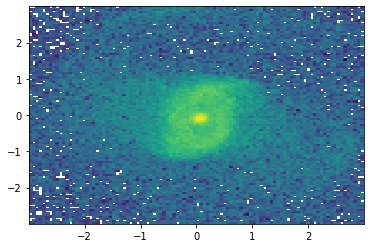

In [35]:
import matplotlib as mpl
xmin = -3
xmax = 3
ymin = -3
ymax = 3

pos = sn.part4.pos - np.array([200, 200, 200])

xbool = np.logical_and(pos[:,0] > xmin, pos[:,0] < xmax)
ybool = np.logical_and(pos[:,1] > ymin, pos[:,1] < ymax)
key = np.logical_and(xbool, ybool)

plt.hist2d(pos[:,0][key], pos[:,1][key], bins=100, weights=sn.part4.mass[key], norm=mpl.colors.LogNorm())
print(sn.Time)
plt.show()

In [39]:

pos_bulge = sn.part3.pos - np.array([200, 200, 200])
pos_star = sn.part4.pos - np.array([200, 200, 200])

r_blg = np.linalg.norm(pos_bulge, axis=1)
r_star = np.linalg.norm(pos_star, axis=1)

print(np.sum(sn.MassTable[3]*len(np.where(r_blg<1.0)[0])))
print(np.sum(sn.part4.mass[r_star < 1.0]))

0.462227405577549
0.021329073
